In [1]:
import ee 
from ee import batch

# Initialize the Earth Engine object, using the authentication credentials.
ee.Initialize()
from make_clim import make_climate

from stack_images_qgis import stacking
from mask_image import define_image
from stratitication import make_strata
from stratitication import prop_allocation
from change_no_change import suit_layer 

from add_neigh import add_neigh
from add_distance import add_distance
#from change_no_change import suit_layer 
import geemap

import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray
from numpy import savetxt
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


val_year = 2015
train_year = 2010
i_year = 1983
#lc_img = define_image(50,0,'tmov',train_year,5) #temporal mov threshold >= 40, 
lc_img_classify = define_image(0,0,'none',train_year,5)
lc_img_for_masking = define_image(50,0,'tmov',train_year,5)

lim_temp_f = ee.FeatureCollection('users/mioash/aust_cd66states')
ucl = ee.FeatureCollection('users/mioash/SUA_2016_AUST')
vic = lim_temp_f.filterMetadata('STE', 'equals', 6)
geom = vic

roads = ee.FeatureCollection('users/verdemuskuna/aus_roads/gis_osm_roads_free_1')
wways = ee.FeatureCollection('users/verdemuskuna/aus_roads/gis_osm_waterways_free_1')
pop = ee.ImageCollection("projects/sat-io/open-datasets/hrsl/hrslpop").median().clip(geom)
nat_npa = ee.Image("users/mioash/drivers_lcaus/natural_areas/nat_npa_ready")
tas_dist_neigh = ee.Image("users/mioash/Calderon_etal_Australian_land-cover/Tas_neigh_dists_c2005")

proj = lc_img_classify.projection()
#################CHANGE ACCESSIBILITY

fst_img = stacking(train_year-10,train_year-5,'mean',False,False) # initial year, end year, reducer for climate, get climate, get precipitation
bfst = fst_img.bandNames().getInfo()

#clm_mean = stacking(train_year-10,train_year-5,'p50',True,True)
# clm_lterm = stacking(i_year,train_year-5,'p50',True,True)
# clm_anomaly = clm_mean.subtract(clm_lterm)

# bn = clm_anomaly.bandNames().getInfo()
# bn = ["{}{}".format(i,str('_anom')) for i in bn]
# clm_anomaly = clm_anomaly.rename(bn) 


roads = roads.filter(ee.Filter.inList('fclass', ['motorway','trunk','primary','secondary','unclassified','tertiary','residential','living_street']))
rd = ee.Image(0).paint(roads,'code').updateMask(fst_img.select('cindex'))
rd = rd.updateMask(rd.neq(0))
dist_roads = rd.select('constant').fastDistanceTransform(1000).sqrt().multiply(ee.Image.pixelArea().sqrt())#//.divide(1000000)//.clip(to_clip)
dist_roads = dist_roads.rename('dist_roads').updateMask(fst_img.select('cindex').add(100))

#dist_roads = dist_roads.expression(
#  '(1 + (1/dd))',{
#  'dd': dist_roads.select(['dist_roads'])
#}).rename('dist_roads')


wways = wways.filter(ee.Filter.inList('fclass', ['river']))
ww = ee.Image(0).paint(wways,'code').updateMask(fst_img.select('cindex'))
ww = ww.updateMask(ww.neq(0))
dist_wways = ww.select('constant').fastDistanceTransform(1000).sqrt().multiply(ee.Image.pixelArea().sqrt())#//.divide(1000000)//.clip(to_clip)
dist_wways = dist_wways.rename('dist_wways').updateMask(fst_img.select('cindex').add(100))

pop = pop.unmask(0).reproject(proj.atScale(30))#.clip(geom)
pop = pop.select('b1').rename('pop')

img_for_train = lc_img_classify.addBands(fst_img).addBands(dist_roads).addBands(dist_wways).addBands(pop)

lcclasses = [0,1,2,3,4]
cpixels = [15,15,15,15,15]

#imgn = img_for_train
idist = img_for_train.select('lc_t1').rename('lc_temp')

for i in range(0,len(lcclasses)):
    idist = add_distance(idist,lcclasses[i],'lc_temp',geom,cpixels[i])

idist = idist.select(idist.bandNames().remove(str('lc_t1')).getInfo())
idist = idist.select(idist.bandNames().remove(str('lc_temp')).getInfo())

nat_npa = nat_npa.select('npa')
to_test = ee.Image(0).clip(geom).where(nat_npa,1)
to_test = to_test.rename('npa')

distto_npa = add_distance(to_test,1,'npa',geom,1)
distto_npa = distto_npa.rename(['npa','distto_npa'])


img_for_train = img_for_train.addBands(distto_npa.select('distto_npa')).addBands(idist)
#add_neigh(image,size,size_centre,blank):

ineigh = ee.Image(1).addBands(add_neigh(lc_img_classify.select('lc_t1'),3,1,False,'_nb')) #-> r=1
ineigh = ineigh.addBands(add_neigh(lc_img_classify.select('lc_t1'),9,3,True,'_3b')) #-> r=4
#ineigh = ineigh.addBands(add_neigh(lc_img.select('lc_t1'),9,1,False,'_nb')) #-> r=4

ineigh = ineigh.addBands(add_neigh(lc_img_classify.select('lc_t1'),27,9,True,'_9b')) #-> r=13
#ineigh = ineigh.addBands(add_neigh(lc_img.select('lc_t1'),27,1,False,'_nb')) #-> r=13

ineigh = ineigh.addBands(add_neigh(lc_img_classify.select('lc_t1'),67,27,True,'_27b')) #-> r=33
#ineigh = ineigh.addBands(add_neigh(lc_img.select('lc_t1'),67,1,False,'_nb')) #-> r=33

img_for_train = img_for_train.addBands(ineigh)
# img_for_train = img_for_train.addBands(add_neigh(lc_img.select('lc_t1'),3,1,False,'_nb')) #-> r=1

# img_for_train = img_for_train.addBands(add_neigh(lc_img.select('lc_t1'),9,3,True,'_3b')) #-> r=4
# img_for_train = img_for_train.addBands(add_neigh(lc_img.select('lc_t1'),9,1,False,'_nb')) #-> r=4

# img_for_train = img_for_train.addBands(add_neigh(lc_img.select('lc_t1'),27,9,True,'_9b')) #-> r=13
# img_for_train = img_for_train.addBands(add_neigh(lc_img.select('lc_t1'),27,1,False,'_nb')) #-> r=13

# img_for_train = img_for_train.addBands(add_neigh(lc_img.select('lc_t1'),67,27,True,'_27b')) #-> r=33
# img_for_train = img_for_train.addBands(add_neigh(lc_img.select('lc_t1'),67,1,False,'_nb')) #-> r=33


im_to_exp = idist.addBands(distto_npa.select('distto_npa')).addBands(ineigh).addBands(dist_roads).addBands(dist_wways)

img_ready = lc_img_classify.addBands(fst_img).addBands(tas_dist_neigh).addBands(pop)
img_readya = img_ready.updateMask(lc_img_for_masking.add(1).select('lc_dep'))
img_readya = img_readya.unmask(-9999,False).updateMask(lc_img_classify.add(ee.Image(1)).select('lc_t1'))

bbands = img_ready.bandNames().getInfo()
#print(bbands)

def myproperties(feature):
  feature=ee.Feature(feature).setGeometry(None)
  return feature

def LatLonImg(img,bands_to_get,npts,binary):
   
    img = img.addBands(ee.Image.pixelLonLat())
    if binary is True:
        strat = make_strata(img,2,True)
    else:
        strat = make_strata(img,6,False)
    ssamples = prop_allocation(ee.Image(strat).toInt(),geom,npts)
    # ssamples = img.sampleRegions(collection= ssamples, 
    #                              scale= 30,
    #                              tileScale=2)
    
    ssamples = img.reduceRegion(reducer=ee.Reducer.toList(),\
                                geometry = ssamples, \
                                 scale= 30,\
                                 tileScale=2)
    
    #tvals = tvals.map(myproperties)
    #ssamples = ssamples.map(myproperties)
    #print(ssamples.getInfo())
    # img = img.reduceRegion(reducer=ee.Reducer.toList(),\
    #                                     geometry=region,\
    #                                     maxPixels=1e13,\
    #                                     scale=30,\
    #                                     tileScale= 2);
 
    #sa2id = np.array((ee.Array(img.get("sa2_id")).getInfo()))#.astype('i4')
    lats = np.array((ee.Array(ssamples.get("latitude")).getInfo()))#.astype('i4')
    lons = np.array((ee.Array(ssamples.get("longitude")).getInfo()))#.astype('i4')
    arr = np.vstack([lats, lons])
    
    for i in range(0,len(bands_to_get)):
         bx = np.array((ee.Array(ssamples.get(str(bands_to_get[i]))).getInfo()))
         arr = np.vstack([arr,bx])
    #arr = arr
    # cr = np.array((ee.Array(img.get("prob_crop")).getInfo()))#.astype('i4')
    # fr = np.array((ee.Array(img.get("prob_forest")).getInfo()))#.astype('i4')
    # gr= np.array((ee.Array(img.get("prob_grass")).getInfo()))#.astype('i4')
    # ur= np.array((ee.Array(img.get("prob_urban")).getInfo()))#.astype('i4')
    # ot= np.array((ee.Array(img.get("prob_other")).getInfo()))#.astype('i4')
    # lprev= np.array((ee.Array(img.get("b2005")).getInfo()))#.astype('i4')
    # lpred= np.array((ee.Array(img.get("b2010")).getInfo()))#.astype('i4')
    #arr = np.vstack([lats, lons, sa2id, cr, fr, gr, ur, ot, lprev, lpred]).transpose()
    return arr.transpose()


In [2]:
lc_cnc_c = suit_layer(lc_img_classify,'binary',True,0)#c
lc_cnc_f = suit_layer(lc_img_classify,'binary',True,1)#f
lc_cnc_g = suit_layer(lc_img_classify,'binary',True,2)#g
lc_cnc_u = suit_layer(lc_img_classify,'binary',True,3)#u
#lc_cnc_w = suit_layer(lc_img_classify,'binary',True,4)#w
#lc_cnc_o = suit_layer(lc_img_classify,'binary',True,5)#o

Map = geemap.Map(center=[-37.74,144.93], zoom=7)

Map.add_basemap("SATELLITE")

#Map.addLayer(ee.Image(strat).clip(geom), {'bands':['strata'],'min': 100, 'max': 410, 'opacity':1}, 'strat')
Landcover_vispar = {'bands':['lc_dep'],"opacity":1,"min":0,"max":1,"palette":["FFEE88","882255"]}
#Map.addLayer(img_for_train, Landcover_vispar, 'Dep')
#Map.addLayer(lc_cnc.clip(geom), '', 'cnc')

Map.addLayer(lc_cnc_c, Landcover_vispar, 'Dep')

Map



Map(center=[-37.74, 144.93], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(…

In [25]:
lc_imgb = lc_cnc_u
lcclass = 'urban'

band_multi = img_ready.bandNames().getInfo()
#band_multi = band_multi.remove(['lc_dep', 'lc_t1', 'lc_t2', 'lc_t3', 'lc_t4', 'lc_t5'])
item_list = [e for e in band_multi if e not in ('lc_dep', 'lc_t1', 'lc_t2', 'lc_t3', 'lc_t4', 'lc_t5')]
lc_imgb = lc_imgb.addBands(img_ready.select(item_list)) 

lc_imgba = lc_imgb.updateMask(lc_img_for_masking.add(1).select('lc_dep'))
lc_imgba = lc_imgb.unmask(-9999,False).updateMask(lc_img_classify.add(ee.Image(1)).select('lc_t1'))
print(lc_imgb.bandNames().getInfo())
Map.addLayer(lc_imgb, {'min':0,'max':1}, 'Binary')

['lc_dep', 'lc_t1', 'lc_t2', 'lc_t3', 'lc_t4', 'lc_t5', 'cindex', 'elevation', 'slope', 'aspect', 'landforms', 'DES_000_200_EV', 'SOC', 'BDW', 'CLY', 'SLT', 'SND', 'PH', 'AWC', 'NTO', 'PTO', 'p01', 'p05', 'p06', 'p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14', 'p16', 'p17', 'p18', 'p19', 'tenure2013', 'tenure2018', 'distto_0', 'distto_1', 'distto_2', 'distto_3', 'distto_4', 'distto_npa', 'constant', 'c_3_nb', 'f_3_nb', 'g_3_nb', 'b_3_nb', 'w_3_nb', 'o_3_nb', 'c_9_3b', 'f_9_3b', 'g_9_3b', 'b_9_3b', 'w_9_3b', 'o_9_3b', 'c_9_nb', 'f_9_nb', 'g_9_nb', 'b_9_nb', 'w_9_nb', 'o_9_nb', 'c_27_9b', 'f_27_9b', 'g_27_9b', 'b_27_9b', 'w_27_9b', 'o_27_9b', 'c_27_nb', 'f_27_nb', 'g_27_nb', 'b_27_nb', 'w_27_nb', 'o_27_nb', 'c_67_27b', 'f_67_27b', 'g_67_27b', 'b_67_27b', 'w_67_27b', 'o_67_27b', 'c_67_nb', 'f_67_nb', 'g_67_nb', 'b_67_nb', 'w_67_nb', 'o_67_nb', 'dist_roads', 'dist_wways', 'pop']


In [26]:
pts_multi = LatLonImg(img_readya, bbands,15000, False)
pts_binary = LatLonImg(lc_imgba, bbands,20000, True)

pts_multi = pts_multi[pts_multi[:,2] != -9999,:]
pts_binary = pts_binary[pts_binary[:,2] != -9999,:]
print(np.shape(pts_multi))
print(np.shape(pts_binary))
#pts = pts[pts[:,2] != 4,:]
#pts = pts[pts[:,2] != 5,:]
#print(np.shape(pts))

(90004, 91)
(48978, 91)


['elevation', 'slope', 'aspect', 'landforms', 'DES_000_200_EV', 'SOC', 'BDW', 'CLY', 'SLT', 'SND', 'PH', 'AWC', 'NTO', 'PTO', 'p01', 'p05', 'p06', 'p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14', 'p16', 'p17', 'p18', 'p19', 'tenure2013', 'tenure2018', 'distto_0', 'f_3_nb', 'g_3_nb', 'b_3_nb', 'w_3_nb', 'o_3_nb', 'f_9_3b', 'g_9_3b', 'b_9_3b', 'w_9_3b', 'o_9_3b', 'c_9_nb', 'f_9_nb', 'g_9_nb', 'b_9_nb', 'w_9_nb', 'o_9_nb', 'f_27_9b', 'g_27_9b', 'b_27_9b', 'w_27_9b', 'o_27_9b', 'c_67_nb', 'f_67_nb', 'g_67_nb', 'b_67_nb', 'w_67_nb', 'o_67_nb']


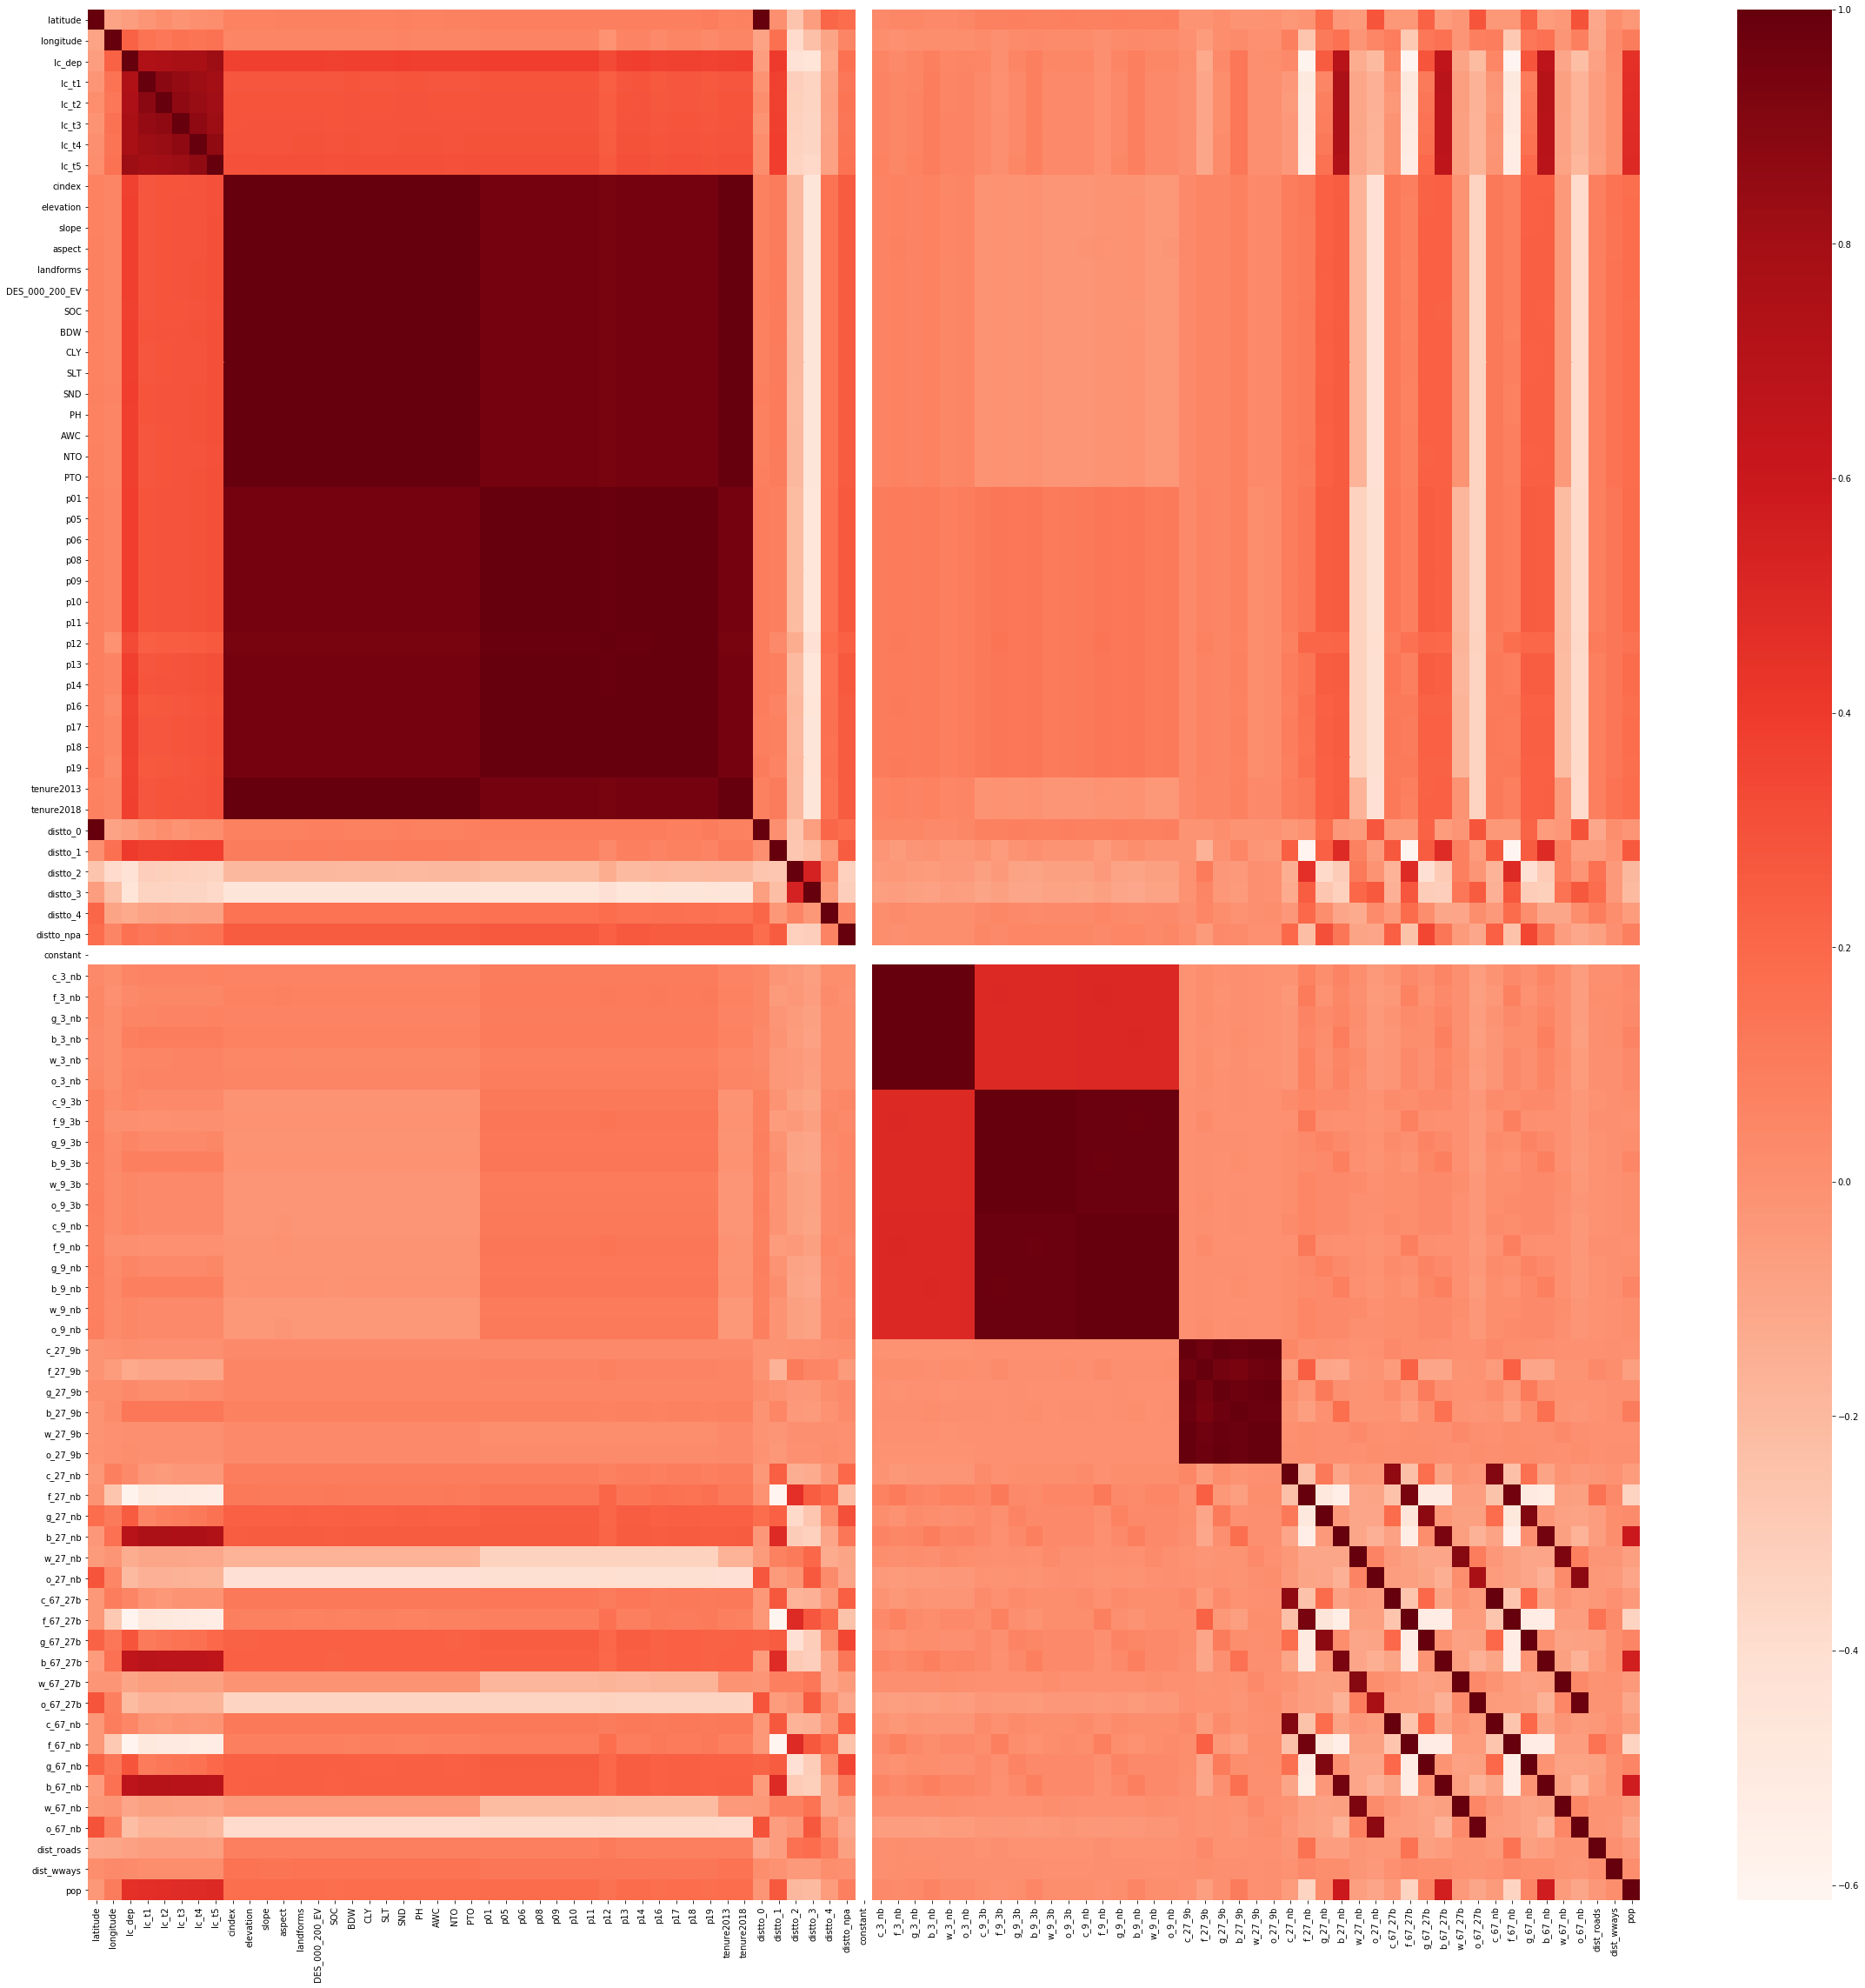

,latitude,longitude,lc_dep,lc_t1,lc_t2,lc_t3,lc_t4,lc_t5,cindex,elevation,...,o_67_27b,c_67_nb,f_67_nb,g_67_nb,b_67_nb,w_67_nb,o_67_nb,dist_roads,dist_wways,pop
0,-39.641710,148.003058,0.0,0.0,0.0,0.0,0.0,0.0,235.0,2.0,...,2.819149,1.871658,14.884135,4.010695,0.0,0.000000,5.035651,9344.194721,1.219191e+06,0.0
1,-39.643058,148.002788,0.0,0.0,0.0,0.0,0.0,0.0,232.0,6.0,...,3.537234,2.049911,17.691622,4.857398,0.0,0.000000,5.815508,9214.013714,1.219179e+06,0.0
2,-39.651412,147.985271,0.0,0.0,0.0,0.0,0.0,0.0,-9999.0,-9999.0,...,5.824468,0.245098,50.378788,2.896613,0.0,0.155971,6.038324,-9999.000000,-9.999000e+03,0.0
3,-39.651682,147.985271,0.0,0.0,0.0,0.0,0.0,0.0,-9999.0,-9999.0,...,5.771277,0.200535,51.247772,3.052585,0.0,0.155971,5.993761,-9999.000000,-9.999000e+03,0.0
4,-39.652221,148.003597,0.0,0.0,0.0,0.0,0.0,0.0,224.0,7.0,...,5.106383,2.361854,17.647059,5.236185,0.0,0.000000,5.392157,8452.756551,1.219100e+06,0.0


In [32]:
#print(pts)
#Using Pearson Correlation
import seaborn as sns
plt.figure(figsize=(40,40))
pts = pts_binary

nbands = ['latitude','longitude']+bbands#,'lc_dep','lc_t1','lc_t2','lc_t3','lc_t4','lc_t5','constant']#+bbands

pts_mx = pd.DataFrame(data=pts, columns=nbands)
#pts_mx.to_csv(path_or_buf='tas_1st_test.csv',index=False)

###find correlated variables
corr_matrix = pts_mx.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

labels = np.array(pts_mx['lc_dep'])
print(to_drop)

# Remove the labels from the features
# axis 1 refers to the columns
cor = pts_mx.corr()
sns.heatmap(cor, cmap=plt.cm.Reds)
plt.show()

pts_mx.head()

In [55]:
dont_use_multi = ['c_9_nb', 'f_9_nb', 'g_9_nb', 'b_9_nb', 'w_9_nb', 'o_9_nb',
                  'c_27_nb', 'f_27_nb', 'g_27_nb', 'b_27_nb', 'w_27_nb', 'o_27_nb',
            'c_67_nb', 'f_67_nb', 'g_67_nb', 'b_67_nb', 'w_67_nb', 'o_67_nb',
            'tenure2018','constant','lc_dep','latitude','longitude','aspect','landforms',
            'DES_000_200_EV','PTO','AWC','c_67_27b', 'f_67_27b', 'g_67_27b', 'b_67_27b', 'w_67_27b', 'o_67_27b',
            ##highly_correlated
            'BDW', 'CLY', 'SLT', 'SND', 'PH', 'AWC', 'NTO', 'PTO','p05', 'p08', 'p10', 'p11',  'p16',
            'p17', 'p18', 'p19',]

dont_use_crop = ['c_9_nb', 'f_9_nb', 'g_9_nb', 'b_9_nb', 'w_9_nb', 'o_9_nb',
            'c_27_nb', 'f_27_nb', 'g_27_nb', 'b_27_nb', 'w_27_nb', 'o_27_nb',
            'c_67_nb', 'f_67_nb', 'g_67_nb', 'b_67_nb', 'w_67_nb', 'o_67_nb',
            'tenure2018','constant','lc_dep','latitude','longitude',
                ##low_importance
            'p14','p16', 'p17', 'p18', 'p19', 'BDW', 'SND', 'AWC', 'NTO', 'PTO','DES_000_200_EV','aspect','landforms',
                 #correlated
                'p05', 'p11', 'p13']

dont_use_forest = ['c_9_nb', 'f_9_nb', 'g_9_nb', 'b_9_nb', 'w_9_nb', 'o_9_nb',
            'c_27_nb', 'f_27_nb', 'g_27_nb', 'b_27_nb', 'w_27_nb', 'o_27_nb',
            'c_67_nb', 'f_67_nb', 'g_67_nb', 'b_67_nb', 'w_67_nb', 'o_67_nb',
            'tenure2018','constant','lc_dep','latitude','longitude',
                ##low_importance
            'p16', 'p17', 'p18', 'p19','SOC','CLY','PH', 'BDW', 'SND', 'AWC', 'NTO', 'PTO','DES_000_200_EV',
                   'aspect','landforms',]
                 #correlated
            #    'p05', 'p11', 'p13']

        
dont_use_urban = ['c_9_nb', 'f_9_nb', 'g_9_nb', 'b_9_nb', 'w_9_nb', 'o_9_nb',
                  'c_9_3b', 'f_9_3b', 'g_9_3b', 'b_9_3b', 'w_9_3b', 'o_9_3b',
            'c_27_nb', 'f_27_9b', 'g_27_9b', 'b_27_9b', 'w_27_9b', 'o_27_9b',
            'c_27_9b', 'f_27_nb', 'g_27_nb', 'b_27_nb', 'w_27_nb', 'o_27_nb',
            'c_67_nb', 'f_67_nb', 'g_67_nb', 'b_67_nb', 'w_67_nb', 'o_67_nb',
            'c_67_27b', 'f_67_27b', 'g_67_27b', 'b_67_27b', 'w_67_27b', 'o_67_27b',
            'tenure2018','constant','lc_dep','latitude','longitude',
                ##low_importance
            'tenure2013','SOC','CLY','PH', 'BDW', 'NTO', 'PTO','DES_000_200_EV',
                   'aspect','landforms','AWC','distto_npa','dist_wways','p09','p14','p13','p16', 'p17', 'p18', 'p19',
                 'distto_0','distto_2','distto_4','SLT']
           # 'p16', 'p17', 'p18', 'p19','S
                           
dont_use_grass = ['c_9_nb', 'f_9_nb', 'g_9_nb', 'b_9_nb', 'w_9_nb', 'o_9_nb',
            'c_27_nb', 'f_27_nb', 'g_27_nb', 'b_27_nb', 'w_27_nb', 'o_27_nb',
            'c_67_nb', 'f_67_nb', 'g_67_nb', 'b_67_nb', 'w_67_nb', 'o_67_nb',
            'tenure2018','constant','lc_dep','latitude','longitude',
                ##low_importance
            'SOC','CLY', 'BDW', 'NTO', 'SLT', 'PTO','DES_000_200_EV','elevation','slope','cindex',
                    'aspect','landforms','AWC','distto_npa','dist_wways','pop',
                  'p08','p12','p13','p09','p14','p16', 'p18','SND','dist_roads','distto_0','distto_4','distto_3']
#                  'distto_0','distto_2','distto_4','SLT']
#            # 'p16', 'p17', 'p18', 'p19','S
                           

        
dont_use = dont_use_urban

features= pts_mx.drop(dont_use, axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)
print(feature_list)
# Convert to numpy array
features = np.array(features)

acc = np.zeros((10,2))

for i in range(4,5):
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = i/10,
                                                                                random_state = 55)
    # Instantiate model 
#     rf = RandomForestClassifier(n_estimators= 100, random_state=55, max_depth= 30, 
#                                 min_samples_leaf= 4,min_samples_split= 2)
    rf = RandomForestClassifier(n_estimators= 100, random_state=55)
    # Train the model on training data
    rf.fit(train_features, train_labels)
    
    y_pred = rf.predict(test_features)
    
    acco = int(accuracy_score(test_labels, y_pred)*1000)
    acc[i-1,0] = acco
    acc[i-1,1] = np.shape(train_features)[0]
    
    #print(confusion_matrix(test_labels,y_pred))
    #print(classification_report(test_labels,y_pred))
    #print(accuracy_score(test_labels, y_pred))

acc

['lc_t1', 'lc_t2', 'lc_t3', 'lc_t4', 'lc_t5', 'cindex', 'elevation', 'slope', 'SND', 'p01', 'p05', 'p06', 'p08', 'p10', 'p11', 'p12', 'distto_1', 'distto_3', 'c_3_nb', 'f_3_nb', 'g_3_nb', 'b_3_nb', 'w_3_nb', 'o_3_nb', 'dist_roads', 'pop']


array([[    0.,     0.],
       [    0.,     0.],
       [    0.,     0.],
       [  984., 29386.],
       [    0.,     0.],
       [    0.,     0.],
       [    0.,     0.],
       [    0.,     0.],
       [    0.,     0.],
       [    0.,     0.]])

In [56]:
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(rf, train_features, train_labels, cv=10)

# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: distto_3             Importance: 0.265
Variable: b_3_nb               Importance: 0.144
Variable: lc_t4                Importance: 0.111
Variable: lc_t5                Importance: 0.109
Variable: lc_t3                Importance: 0.079
Variable: lc_t2                Importance: 0.06
Variable: lc_t1                Importance: 0.03
Variable: p10                  Importance: 0.029
Variable: p11                  Importance: 0.023
Variable: dist_roads           Importance: 0.019
Variable: p01                  Importance: 0.018
Variable: p06                  Importance: 0.017
Variable: SND                  Importance: 0.016
Variable: f_3_nb               Importance: 0.011
Variable: p05                  Importance: 0.01
Variable: p08                  Importance: 0.01
Variable: p12                  Importance: 0.01
Variable: cindex               Importance: 0.009
Variable: elevation            Importance: 0.007
Variable: slope                Importance: 0.007
Variable: pop            

In [46]:
# from sklearn.metrics import confusion_matrix

# y_pred_class = y_pred_pos > threshold
# cm = confusion_matrix(y_true, y_pred_class)
# tn, fp, fn, tp = cm.ravel()


# from sklearn.metrics import roc_auc_score

# roc_auc = roc_auc_score(test_labels, y_pred)
# from scikitplot.metrics import plot_roc

# fig, ax = plt.subplots()
# plot_roc(test_labels, y_pred, ax=ax)

from sklearn.metrics import confusion_matrix

#y_pred_class = y_pred_pos > threshold
cm = confusion_matrix(test_labels, y_pred)
tn, fp, fn, tp = cm.ravel()
tn
#fp
#fn
#tp

11430

In [39]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [ ]:
##random search
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 50, 100, 150 , 200, 500]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfa = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfa, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 16)# Fit the random search model
rf_random.fit(train_features, train_labels)

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    #errors = abs(predictions - test_labels)
    #mape = 100 * np.mean(errors / test_labels)
    #accuracy = 100 - mape
    #rrmse = np.sqrt(metrics.mean_squared_error(test_labels, predictions))
    #nrmse = rrmse / np.mean(test_labels)
    acco = accuracy_score(test_labels, y_pred)
    print('Model Performance')
    print(acco)
    #print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    #print('Accuracy = {:0.2f}%.'.format(accuracy))
    #print('RMSE: ', rrmse)
    #print('NRMSE: ', nrmse)    
    return RandomForestClassifier(n_estimators = 100, random_state = 42)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)

rf_random.best_params_

In [ ]:
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 10, 20, 40],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 3, 4, 5, 10, 50, 250,300],
    'min_samples_split': [1, 2, 3, 10, 50],
    'n_estimators': [100, 200]
}# Create a based model
rfb = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfb, param_grid = param_grid, 
                          cv = 5, n_jobs = 32, verbose = 2)
grid_search.fit(train_features, train_labels)
grid_search.best_params_
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

In [ ]:
grid_search.best_params_
#feature_list

In [57]:
#print(lc_change.bandNames().getInfo())
#feature_list

# trainingvals1 = lc_imgb.sampleRegions(
#                             collection= ssamples, 
#                             scale= 30,
#                             tileScale=8)

strat = make_strata(lc_imgba,2,True)
#strat = make_strata(img,6,False)
ssamples = prop_allocation(lc_imgba.addBands(ee.Image(strat).toInt()),geom,10000)
    
mtry = round(len(feature_list)*(2/3),0)
#print(mtry)
classifier1 = ee.Classifier.smileRandomForest(numberOfTrees=100,
                                               variablesPerSplit =mtry ,
                                              minLeafPopulation=4,
                                             maxNodes = 40, seed = 55).setOutputMode('PROBABILITY')
#classifier2 = ee.Classifier.libsvm('Voting','C_SVC','RBF',True,None,0.5)

#Train the classifier.
trainer1 = classifier1.train(features=ssamples,classProperty ='lc_dep',
                            inputProperties= feature_list)
#trainer2 = classifier2.train(trainingvals,'lc_dep')

classified1 = lc_imgb.classify(trainer1).toDouble()

geometri = ee.Geometry.Rectangle([143.537,-43.89,148.965,-39.42]) #//#tas

ee.batch.Export.image.toAsset(image=classified1,
                              description='Tas_lc2010_tunnedv1_n67_n27_n9'+lcclass,
                              assetId='users/mioash/Calderon_etal_Australian_land-cover/Tas_lc2010_tunnedv1_n67_n27_n9'+lcclass,scale=30,
                             region = geometri,maxPixels=1e13,crs='EPSG:4326').start()

In [ ]:
print(ssamples.size().getInfo())

In [ ]:
from geemap import ml

trees =  ml.rf_to_strings(rf,feature_list)

user_id = geemap.ee_user_id()
user_id

ml.export_trees_to_fc(trees,user_id + "/rf_crop_tas_v1")

